# Hourly Load Profile Builder

**Objective**  
Combine hourly daily-shape data with monthly scaling coefficients to build a normalised 8,760-hour load profile for each zone.

**Data requirements (user-provided) and method**  
- Data requirements: `input/load_daily.csv` containing 24-hour shapes per zone (indexed 1-24) and `input/load_monthly.csv` with monthly multipliers per zone, plus an `output/` folder with write access.  
- Method: Load both CSVs into pandas, align calendar metadata, multiply hourly profiles by monthly coefficients, normalise by zone, and plot representative daily/monthly patterns for quality checks.

**Overview of steps**  
1. Step 1 - Import dependencies and load the daily and monthly CSV inputs.  
2. Step 2 - Build the full-year hourly profile and save `output/load_full_year.csv`.  
3. Step 3 - Plot representative daily and monthly profiles for QA.

## 1. User Inputs

Point to the daily shape and monthly scaling CSVs stored under `pre-analysis/prepare-data/input/`. Adjust `target_day` if you want the QA plots to focus on a different slice of the year.

In [1]:
daily_profile_csv = 'input/load_daily.csv'
monthly_profile_csv = 'input/load_monthly.csv'
plot_target_day = 15  # used later when plotting representative days

## 2. Setup: imports and shared configuration

In [2]:
import os
from pathlib import Path

import calendar
import math

import pandas as pd
from matplotlib import pyplot as plt


## 3. Load the daily and monthly inputs

In [3]:
daily_path = Path(daily_profile_csv)
monthly_path = Path(monthly_profile_csv)
if not daily_path.exists():
    raise FileNotFoundError(f"Daily profile file not found: {daily_path}")
if not monthly_path.exists():
    raise FileNotFoundError(f"Monthly profile file not found: {monthly_path}")


daily = pd.read_csv(daily_path, encoding='utf-8', low_memory=False, index_col=[0], header=[0])
monthly = pd.read_csv(monthly_path, encoding='utf-8', low_memory=False, index_col=[0], header=[0])
print(f"Daily profiles loaded with shape {daily.shape}")
print(f"Monthly coefficients loaded with shape {monthly.shape}")

Daily profiles loaded with shape (24, 10)
Monthly coefficients loaded with shape (12, 10)


## 4 - Build and save the hourly profile

In [4]:
def build_hourly_profile(hourly_df, monthly_df):
    """
    Build a full 8760-hour profile from daily hourly shape and monthly scaling coefficients.
    Returns a long-format DataFrame with columns: season, day, hour, zone, value.
    """
    # Ensure index is sorted and labeled properly
    hourly_df = hourly_df.copy()
    monthly_df = monthly_df.copy()


    # Day-of-year and month mapping
    date_range = pd.date_range("2025-01-01", "2026-01-01", freq="h", inclusive="left")
    calendar = pd.DataFrame({
        "datetime": date_range,
        "day": date_range.day,
        "month": date_range.month,
        "hour": date_range.hour + 1  # To match 1–24 indexing
    })


    # Multiply hourly profile by monthly coefficient for each zone
    result = []

    for zone in hourly_df.columns:
        # Check if the zone exists in monthly_df
        if zone not in monthly_df.columns:
            raise ValueError(f"Zone '{zone}' not found in monthly coefficients.")

        # Build a daily profile for the full year for this zone
        daily_values = hourly_df[zone].reindex(calendar["hour"].values).reset_index(drop=True)
        month_coeffs = calendar["month"].map(monthly_df[zone]).reset_index(drop=True)
        full_year_profile = daily_values * month_coeffs

        zone_df = calendar.copy()
        zone_df["value"] = full_year_profile
        zone_df["zone"] = zone
        result.append(zone_df)

    final_df = pd.concat(result, ignore_index=True)
    # Normalize the 'value' column to ensure the max is 1 for each zone
    final_df["value"] = final_df.groupby("zone")["value"].transform(lambda x: x / x.max())


    return final_df[["zone", "month", "day", "hour", "value"]]

load = build_hourly_profile(daily, monthly)
load.to_csv('output/load_full_year.csv', index=False)
print("Exporting full year load profile.")
display(load.head(), load.tail())

Exporting full year load profile.


,zone,month,day,hour,value
0,Angola,1,1,1,0.792514
1,Angola,1,1,2,0.763280
2,Angola,1,1,3,0.752417
3,Angola,1,1,4,0.731385
4,Angola,1,1,5,0.723720


,zone,month,day,hour,value
87595,Chad,12,31,20,0.810526
87596,Chad,12,31,21,0.782052
87597,Chad,12,31,22,0.730636
87598,Chad,12,31,23,0.669705
87599,Chad,12,31,24,0.608863


In [5]:
load

,zone,month,day,hour,value
0,Angola,1,1,1,0.792514
1,Angola,1,1,2,0.763280
2,Angola,1,1,3,0.752417
3,Angola,1,1,4,0.731385
4,Angola,1,1,5,0.723720
...,...,...,...,...,...
87595,Chad,12,31,20,0.810526
87596,Chad,12,31,21,0.782052
87597,Chad,12,31,22,0.730636
87598,Chad,12,31,23,0.669705


## 5 - Plot sample daily and monthly profiles

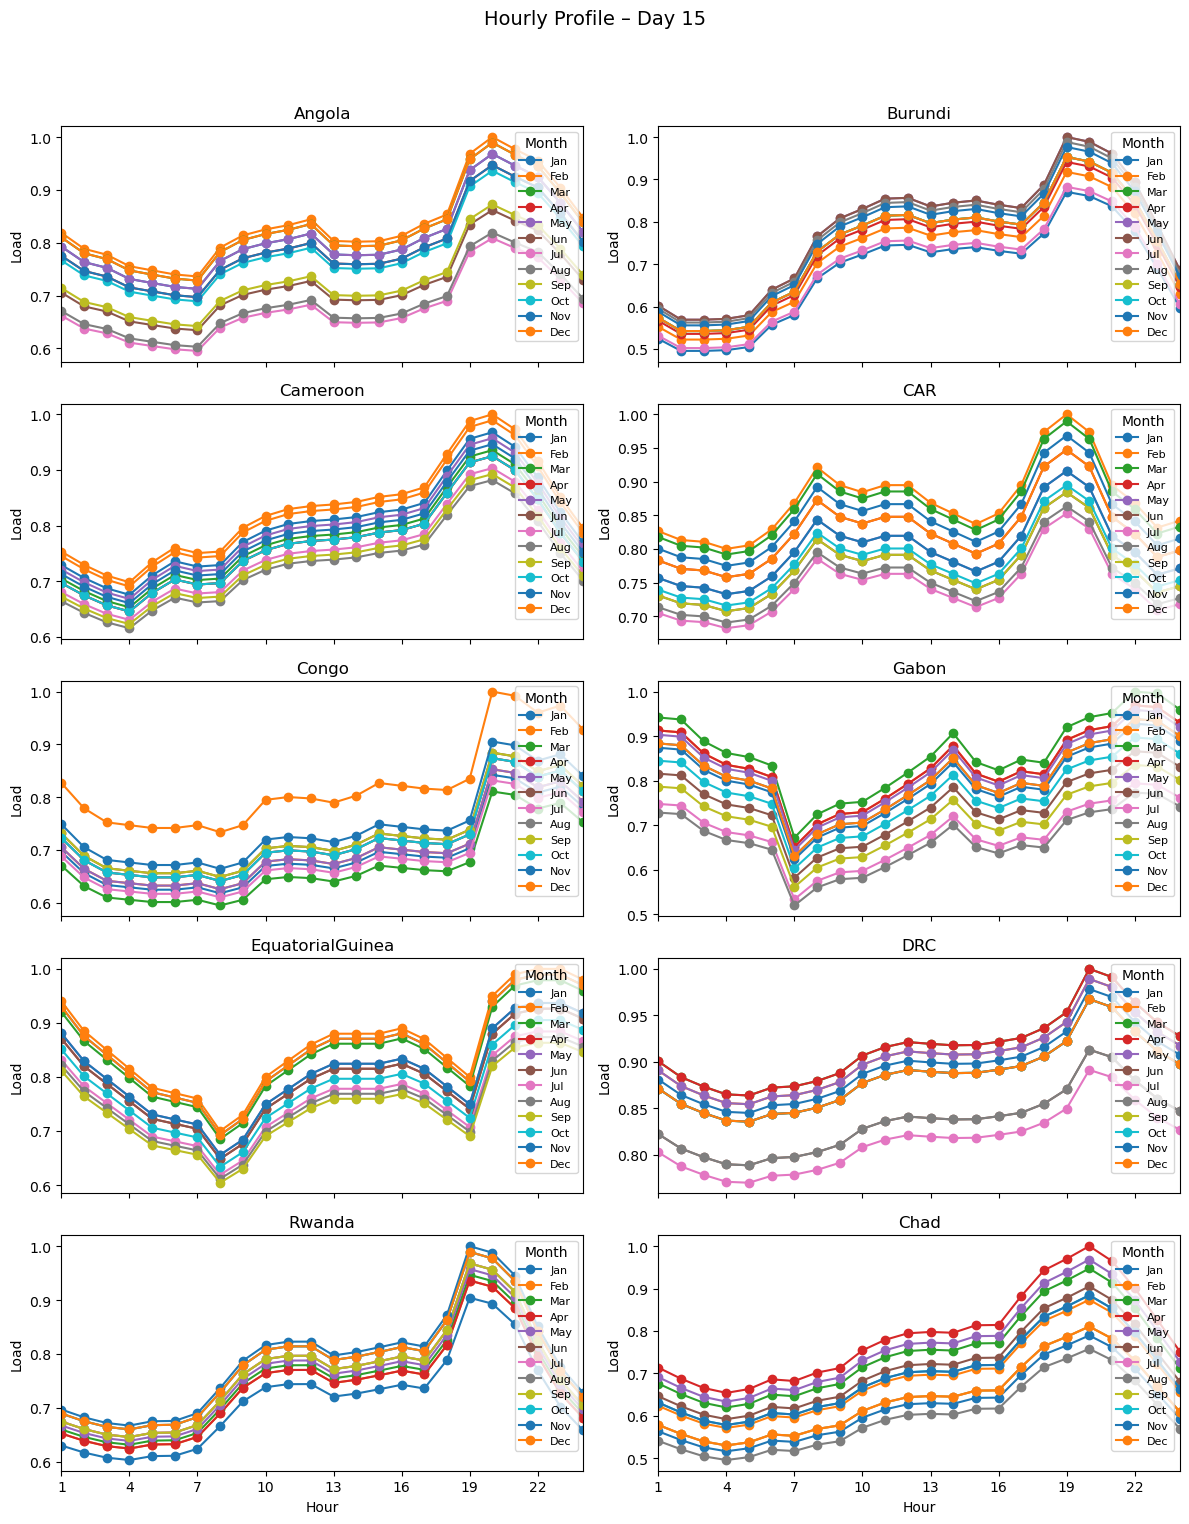

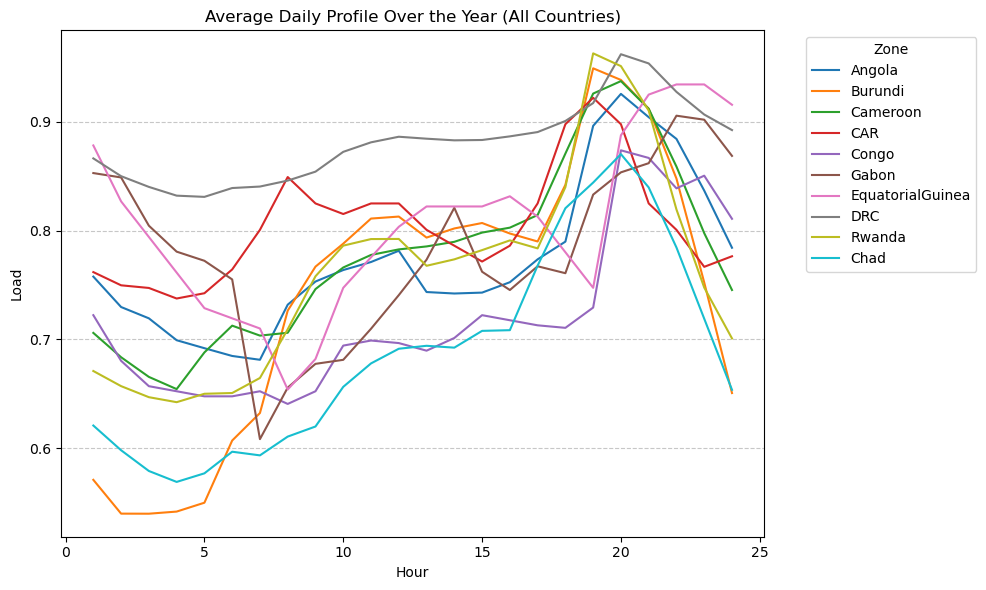

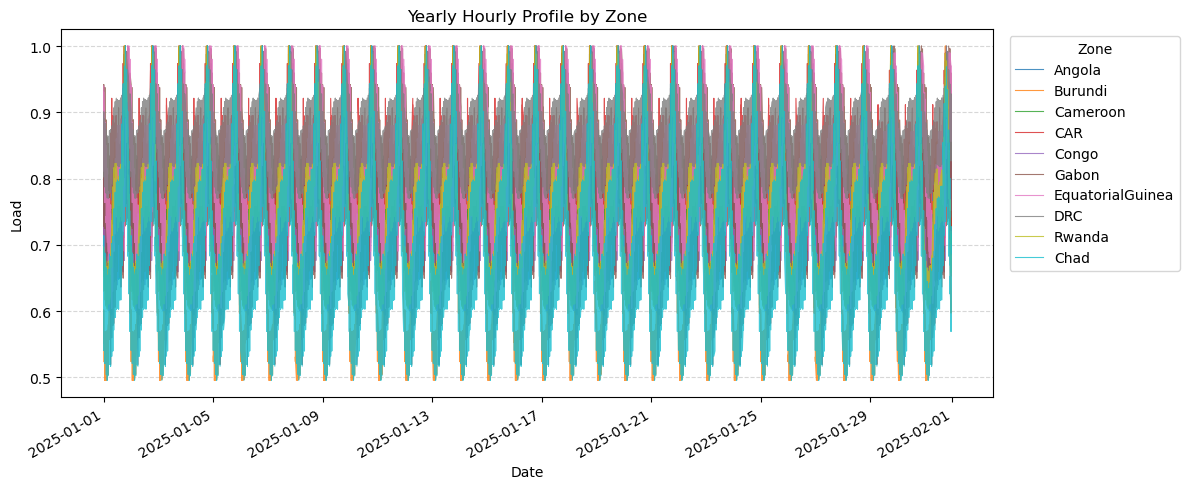

Plots displayed inline. Pass a filename to export as PDF.


In [6]:

def plot_generation_profiles(result_df, target_day=plot_target_day, filename=None):
    """
    Plot representative load-profile views. When ``filename`` is provided the plots
    are exported as PDF files inside the local ``output`` folder; otherwise the
    figures are rendered inline in the notebook.
    """

    # Ensure datetime is available
    if "datetime" not in result_df.columns:
        result_df = result_df.copy()
        result_df["datetime"] = pd.to_datetime("2025-01-01") + pd.to_timedelta(
            (result_df["day"] - 1) * 24 + (result_df["hour"] - 1), unit="h"
        )

    zones = result_df["zone"].unique()
    save_figures = filename is not None
    saved_paths = []
    output_dir = Path("output")
    if save_figures:
        output_dir.mkdir(parents=True, exist_ok=True)

    def handle_output(fig, suffix):
        if save_figures:
            file_path = output_dir / f"{filename}_{suffix}.pdf"
            fig.savefig(file_path, format="pdf", bbox_inches="tight")
            saved_paths.append(file_path)
        else:
            plt.show()
        plt.close(fig)

    def _format_month_label(month_value):
        try:
            month_int = int(month_value)
        except (TypeError, ValueError):
            return str(month_value)
        if 1 <= month_int <= 12:
            return calendar.month_abbr[month_int]
        return f"Month {month_int}"

    # 1. Plot for a specific day (subplots by country)
    ncols = 2
    nrows = math.ceil(len(zones) / ncols)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(12, 3.2 * nrows),
        sharex=True,
    )
    if hasattr(axes, "flat"):
        axes = list(axes.flat)
    else:
        axes = [axes]
    fig.suptitle(f"Hourly Profile – Day {target_day}", fontsize=14)
    for i, zone in enumerate(zones):
        ax = axes[i]
        zone_day = result_df[(result_df["day"] == target_day) & (result_df["zone"] == zone)]
        if zone_day.empty:
            ax.set_title(zone)
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            continue
        zone_day = zone_day.sort_values(["month", "hour"])
        for month, month_df in zone_day.groupby("month"):
            month_df = month_df.sort_values("hour")
            if "month_name" in month_df.columns:
                label = str(month_df["month_name"].iloc[0])
            else:
                label = _format_month_label(month)
            ax.plot(month_df["hour"], month_df["value"], marker="o", label=label)
        ax.set_title(zone)
        ax.set_xlim(1, 24)
        ax.set_xticks(range(1, 25, 3))
        ax.set_ylabel("Load")
        ax.legend(title="Month", fontsize=8, loc="upper right")
        if (i // ncols) == nrows - 1:
            ax.set_xlabel("Hour")
    for ax in axes[len(zones):]:
        ax.set_visible(False)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    handle_output(fig, f"day{target_day}")

    # 2. Monthly average profile (one plot, all countries)
    monthly_avg = (
        result_df.groupby(["month", "hour", "zone"])["value"].mean().reset_index()
    )
    fig, ax = plt.subplots(figsize=(10, 6))
    for zone in zones:
        zdf = monthly_avg[monthly_avg["zone"] == zone]
        avg_by_hour = zdf.groupby("hour")["value"].mean()
        ax.plot(avg_by_hour.index, avg_by_hour.values, label=zone)
    ax.set_title("Average Daily Profile Over the Year (All Countries)")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Load")
    ax.legend(title="Zone", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()
    handle_output(fig, "monthly_average")

    # 3. Yearly profile by country (entire year view)
    fig, ax = plt.subplots(figsize=(12, 5))
    for zone in zones:
        zdf = result_df[result_df["zone"] == zone].sort_values("datetime")
        ax.plot(zdf["datetime"], zdf["value"], label=zone, linewidth=0.8, alpha=0.8)
    ax.set_title("Yearly Hourly Profile by Zone")
    ax.set_xlabel("Date")
    ax.set_ylabel("Load")
    ax.legend(title="Zone", bbox_to_anchor=(1.01, 1), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    fig.autofmt_xdate()
    fig.tight_layout()
    handle_output(fig, "yearly_by_country")

    if save_figures:
        print("Plots saved (PDF):")
        for path in saved_paths:
            print(f"- {path}")
    else:
        print("Plots displayed inline. Pass a filename to export as PDF.")

day_df = plot_generation_profiles(load, 
                         # filename="load",
                         target_day=plot_target_day)
